### Travis James Smith

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"

## Problem 1
We're going to build an autoencoder using Keras. Borrowing and modifying code from lecture and the Geron notebook:

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

We're going to define a model with three hidden layers. The "coding" layer here has size $16$:

In [5]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def build_denoising_ae(coding_layer_size=16):
    denoising_encoder = keras.models.Sequential(
        [
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.GaussianNoise(0.2),
            keras.layers.Dense(coding_layer_size, activation="selu"),
        ]
    )
    denoising_decoder = keras.models.Sequential(
        [
            keras.layers.Dense(100, activation="selu", input_shape=[coding_layer_size]),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape([28, 28]),
        ]
    )
    denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
    denoising_ae.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(lr=1.0),
        metrics=[rounded_accuracy],
    )
    
    return denoising_ae

In [6]:
denoising_16 = build_denoising_ae()
denoising_16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16)                12560     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            80884     
Total params: 93,444
Trainable params: 93,444
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = denoising_16.fit(
    x=X_train, y=X_train, epochs=10, validation_data=[X_valid, X_valid]
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2143 - rounded_accuracy: 0.9029 - val_loss: 0.1691 - val_rounded_accuracy: 0.9272
Epoch 2/10
55000/55000 [==============================] - 3s 56us/sample - loss: 0.1582 - rounded_accuracy: 0.9334 - val_loss: 0.1457 - val_rounded_accuracy: 0.9407
Epoch 3/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.1446 - rounded_accuracy: 0.9407 - val_loss: 0.1387 - val_rounded_accuracy: 0.9443
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.1404 - rounded_accuracy: 0.9427 - val_loss: 0.1360 - val_rounded_accuracy: 0.9455
Epoch 5/10
55000/55000 [==============================] - 3s 56us/sample - loss: 0.1382 - rounded_accuracy: 0.9437 - val_loss: 0.1339 - val_rounded_accuracy: 0.9467
Epoch 6/10
55000/55000 [==============================] - 3s 56us/sample - loss: 0.1366 - rounded_accuracy: 0.9445 - val_loss:

In [8]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [9]:
def get_digit_images(digits):
    images = np.zeros((len(digits), 28, 28), dtype='float32')
    print(images.shape)
    for index, digit in enumerate(digits):
        first_index = np.where(y_train == digit)[0][1]
        image = X_train[first_index]
        images[index] = image
    return images

(5, 28, 28)


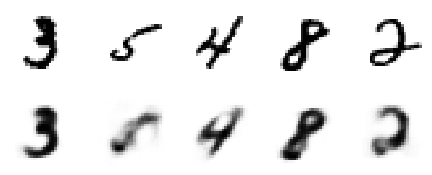

In [10]:
test_images_dae = get_digit_images([3, 5, 4, 8, 2])

show_reconstructions(denoising_16, test_images_dae)
plt.show()

Above we can see the predicted outputs from the original inputs.

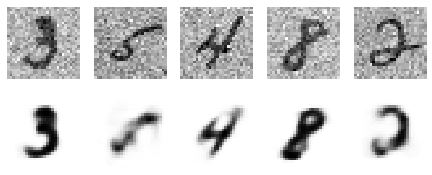

In [11]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_16, noise(test_images_dae, training=True))
plt.show()

And here we can see the outputs relative to the inputs with noise added. 

Now let's try doing all of the above but with a much larger coding layer:

In [12]:
denoising_128 = build_denoising_ae(128)
denoising_128.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 128)               100480    
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            92084     
Total params: 192,564
Trainable params: 192,564
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = denoising_128.fit(
    x=X_train, y=X_train, epochs=10, validation_data=[X_valid, X_valid]
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.1917 - rounded_accuracy: 0.9168 - val_loss: 0.1399 - val_rounded_accuracy: 0.9452
Epoch 2/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.1289 - rounded_accuracy: 0.9505 - val_loss: 0.1145 - val_rounded_accuracy: 0.9593
Epoch 3/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.1136 - rounded_accuracy: 0.9589 - val_loss: 0.1040 - val_rounded_accuracy: 0.9651
Epoch 4/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.1061 - rounded_accuracy: 0.9630 - val_loss: 0.0980 - val_rounded_accuracy: 0.9687
Epoch 5/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.1016 - rounded_accuracy: 0.9656 - val_loss: 0.0944 - val_rounded_accuracy: 0.9706
Epoch 6/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.0984 - rounded_accuracy: 0.9674 - val_loss:

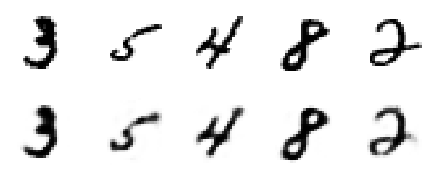

In [14]:
show_reconstructions(denoising_128, test_images_dae)
plt.show()

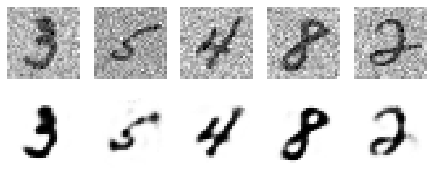

In [15]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_128, noise(test_images_dae, training=True))
plt.show()

These results are clearly better than the model with the coding layer of size $16$!

## Problem 2
Let's try implementing an autoencoder in PyTorch. We'll be drawing on the PyTorch example notebook here:

In [16]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [17]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [18]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [19]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [20]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [21]:
import torch.optim as optim

#  use gpu if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Gaussian noise transformer borrowed from the PyTorch support forums:

In [22]:
from torch.utils.data import Dataset, DataLoader

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0., 0.1)])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=0
)


In [23]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 0.044202
epoch : 2/20, loss = 0.028784
epoch : 3/20, loss = 0.026387
epoch : 4/20, loss = 0.025388
epoch : 5/20, loss = 0.024415
epoch : 6/20, loss = 0.023814
epoch : 7/20, loss = 0.023401
epoch : 8/20, loss = 0.023087
epoch : 9/20, loss = 0.022859
epoch : 10/20, loss = 0.022661
epoch : 11/20, loss = 0.022502
epoch : 12/20, loss = 0.022344
epoch : 13/20, loss = 0.022220
epoch : 14/20, loss = 0.022098
epoch : 15/20, loss = 0.021983
epoch : 16/20, loss = 0.021884
epoch : 17/20, loss = 0.021806
epoch : 18/20, loss = 0.021720
epoch : 19/20, loss = 0.021657
epoch : 20/20, loss = 0.021599


In [24]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

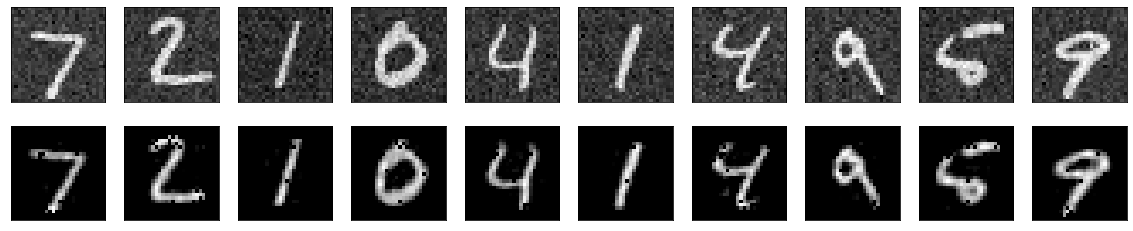

In [25]:
import matplotlib.pyplot as plt

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

This looks pretty good. Not much to complain about here. We could increase the amount of noise introduced, but training unfortunately takes a while (the library doesn't want to use my GPU). I don't think the results would be very different though, proportionally.

## Problem 3
Now we're being asked to build a variational autoencoder and generate samples from it:

In [26]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [27]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [28]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [29]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.2209 - rounded_accuracy: 0.9060 - val_loss: 0.1852 - val_rounded_accuracy: 0.9283
Epoch 2/25
55000/55000 [==============================] - 1s 26us/sample - loss: 0.1764 - rounded_accuracy: 0.9325 - val_loss: 0.1705 - val_rounded_accuracy: 0.9361
Epoch 3/25
55000/55000 [==============================] - 1s 27us/sample - loss: 0.1656 - rounded_accuracy: 0.9390 - val_loss: 0.1634 - val_rounded_accuracy: 0.9406
Epoch 4/25
55000/55000 [==============================] - 1s 26us/sample - loss: 0.1602 - rounded_accuracy: 0.9424 - val_loss: 0.1560 - val_rounded_accuracy: 0.9453
Epoch 5/25
55000/55000 [==============================] - 1s 27us/sample - loss: 0.1569 - rounded_accuracy: 0.9447 - val_loss: 0.1565 - val_rounded_accuracy: 0.9454
Epoch 6/25
55000/55000 [==============================] - 1s 27us/sample - loss: 0.1546 - rounded_accuracy: 0.9461 - val_loss:

In [30]:
def plot_multiple_images(images):
    plt.figure(figsize=(5, 5))
    for index, image in enumerate(images):
        plt.subplot(1, 5, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [31]:
test_images_vae = get_digit_images([3, 4])
test_encodings = variational_encoder(test_images_vae)
test_encodings

(2, 28, 28)


[<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[-0.52421385,  1.0082523 ,  0.2272144 ,  1.9122106 ,  0.3681989 ,
          0.77197343,  0.47688577, -0.13799557, -0.24650046, -1.1945227 ],
        [ 1.443497  , -0.52126706, -0.15408823, -0.7365739 , -1.1665245 ,
          0.90097815, -2.1041713 , -1.0197786 , -0.11397567, -0.6893282 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[-4.0515847, -3.9749691, -3.276582 , -3.6150293, -2.5417054,
         -3.8420749, -3.7949395, -3.7007751, -4.9582453, -2.98279  ],
        [-3.817886 , -3.5286775, -2.6233873, -3.3046684, -2.6068554,
         -3.2417488, -3.0741768, -3.6385536, -4.4246216, -2.5501122]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[-0.39221752,  0.9117677 ,  0.04616685,  1.6280484 ,  0.55269945,
          0.85111004,  0.46671253, -0.35247   , -0.2689966 , -1.0564462 ],
        [ 1.1682177 , -0.10834125,  0.25183487, -0.5801099 , -1.097146  ,
 

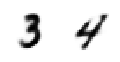

In [32]:
images = variational_decoder(test_encodings).numpy()
plot_multiple_images(images)

In [33]:
print(np.array(test_encodings).shape)

(3, 2, 10)


Let's try and interpolate between these:

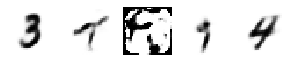

In [34]:
codings_grid = tf.reshape(test_encodings, [1, 1, 6, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[1, 5])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plot_multiple_images(images)

I'm completely at a loss as to why this interpolation isn't working, and why it _was_ working in the Geron notebook with nearly the same code. I'm out of bandwidth to work on it, but maybe I'll circle back around when the class is over.

Now let's try to run these images generated by our VAE through our denoising autoencoder from the first problem. In theory, the denoising autoencoder could reduce the "noise" (blurriness) of these probabilistically generated digits.

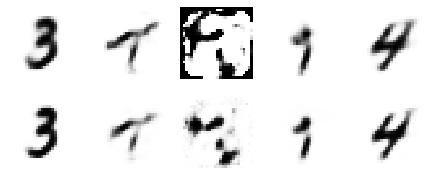

In [35]:
show_reconstructions(denoising_128, images)
plt.show()

Impressively, our denoising autoencoder _does_ actually remove some of the blurriness! It's subtle, but you can see that the boundaries are more sharply defined in the reconstructed images. This is a pretty cool result.